In [26]:
import numpy as np
import networkx as nx
import pandas as pd

from scipy import stats

# import causalpy as cp

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import torch
import pytorch_lightning as pl

from catenets.models.torch import TARNet, SNet, FlexTENet
from models.causal_bert_pytorch.CausalBert import CausalBertWrapper

from econml.metalearners import SLearner, XLearner
from econml.dml import CausalForestDML, NonParamDML
from econml.dr import LinearDRLearner
from lightgbm import LGBMRegressor, LGBMClassifier

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [9]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

# Chapter 11.1

In [10]:
# Set random seed
SEED = 18
np.random.seed(SEED)
pl.seed_everything(SEED)  

Global seed set to 18


## Going Deeper: Deep Learning for Heterogenous Treatment Effects

### Data

In [11]:
SAMPLE_SIZE = 5000
TRAIN_SIZE = 4500
N_FEATURES = 20

X = np.random.normal(0, 1, (SAMPLE_SIZE, N_FEATURES))
T = np.random.binomial(1, 0.5, SAMPLE_SIZE)

weights = np.random.gumbel(5, 10, (SAMPLE_SIZE, N_FEATURES - 1))

y = (50 * T * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)

y0 = (50 * 0 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)
y1 = (50 * 1 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)


In [12]:
effect_true = y1[TRAIN_SIZE:] - y0[TRAIN_SIZE:] 

### S-Learner, X-Learner, DR-Learner & Causal Forest (Benchmark)

In [27]:
benchmark_models = {
    'SLearner': SLearner(overall_model=LGBMRegressor()),
    'XLearner': XLearner(models=LGBMRegressor()),
    'DRLearner': LinearDRLearner(),
    'CausalForest': CausalForestDML(),
    'NonParamDML': NonParamDML(model_final=LGBMRegressor(),model_y=LGBMRegressor(),model_t=LGBMClassifier())
}

benchmark_results = {}


for model_name, model in benchmark_models.items():
    model.fit(
        X=X[:TRAIN_SIZE, :],
        T=T[:TRAIN_SIZE],
        Y=y[:TRAIN_SIZE]
    )

    effect_pred = model.effect(
        X[TRAIN_SIZE:]
    )
    
    benchmark_results[model_name] = effect_pred

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


SLearner MAPE = 3.339113509099748


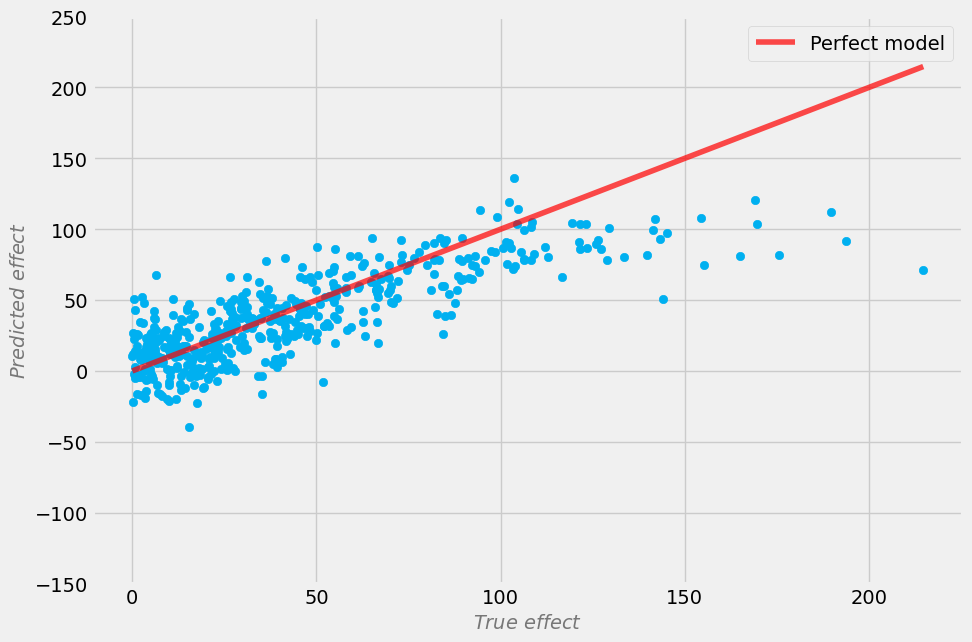

XLearner MAPE = 4.256912689213058


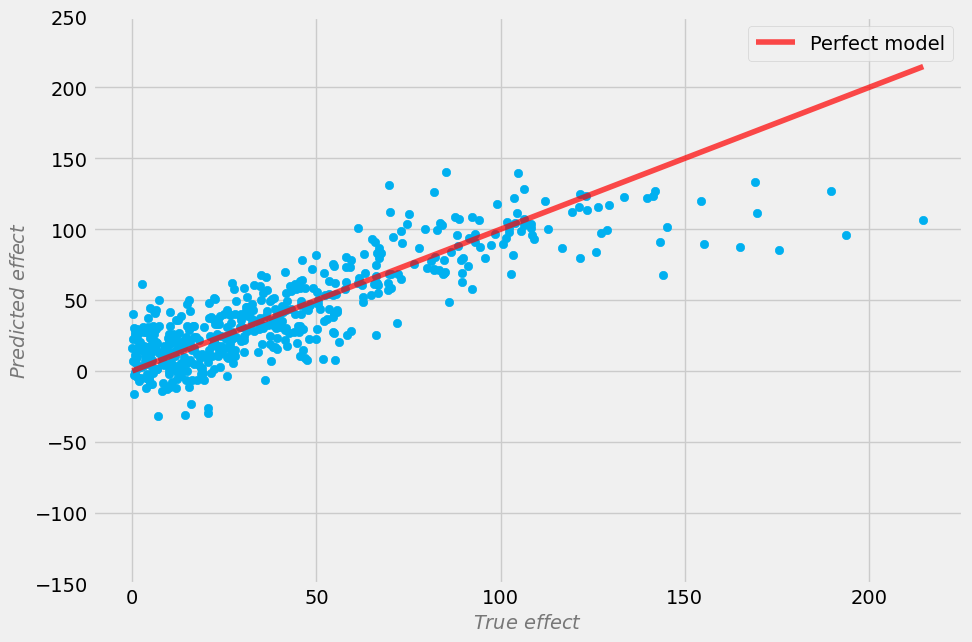

DRLearner MAPE = 8.798849059717112


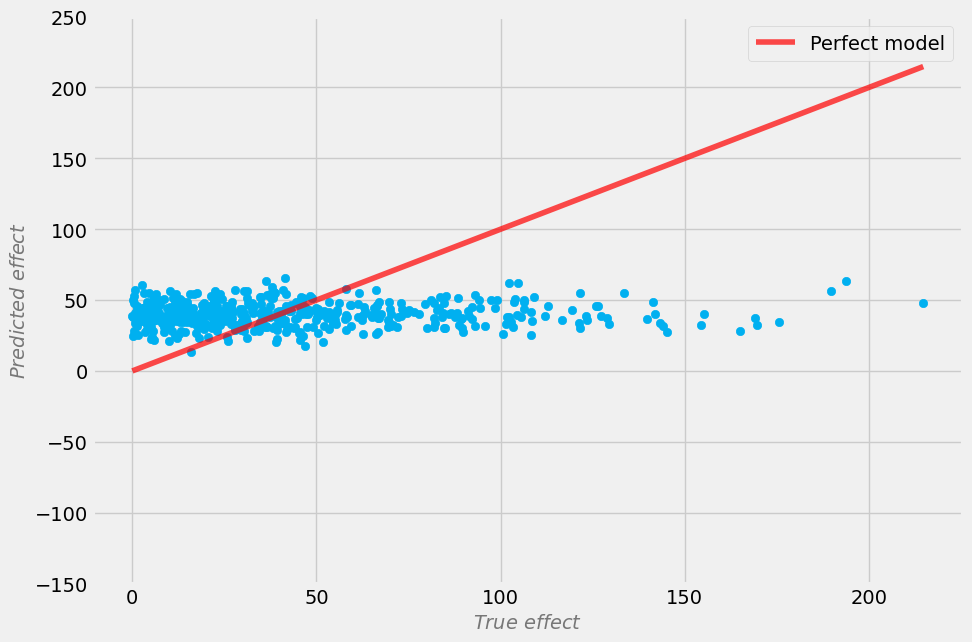

CausalForest MAPE = 2.503891615717866


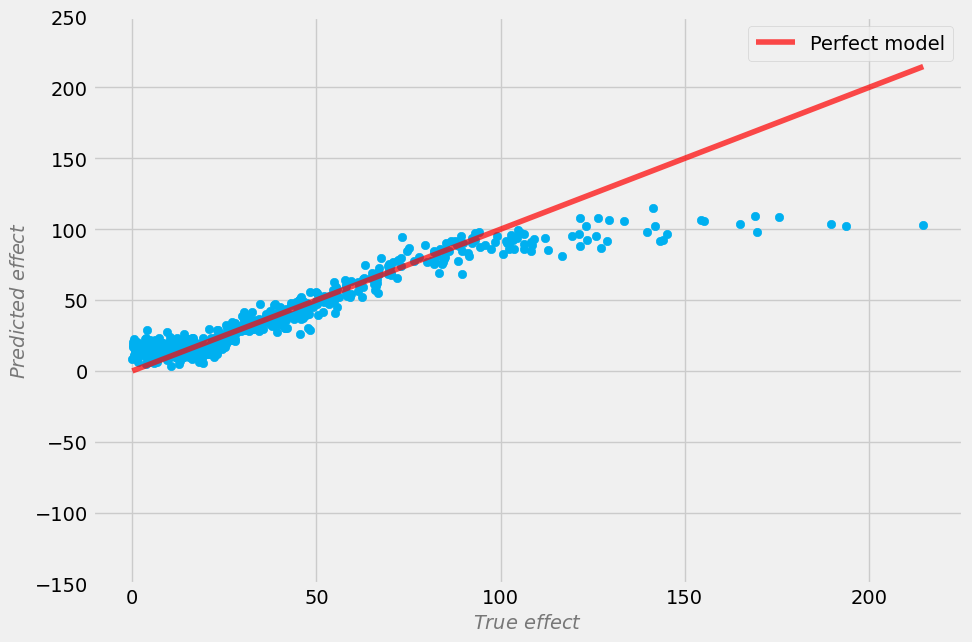

NonParamDML MAPE = 3.0604153494465605


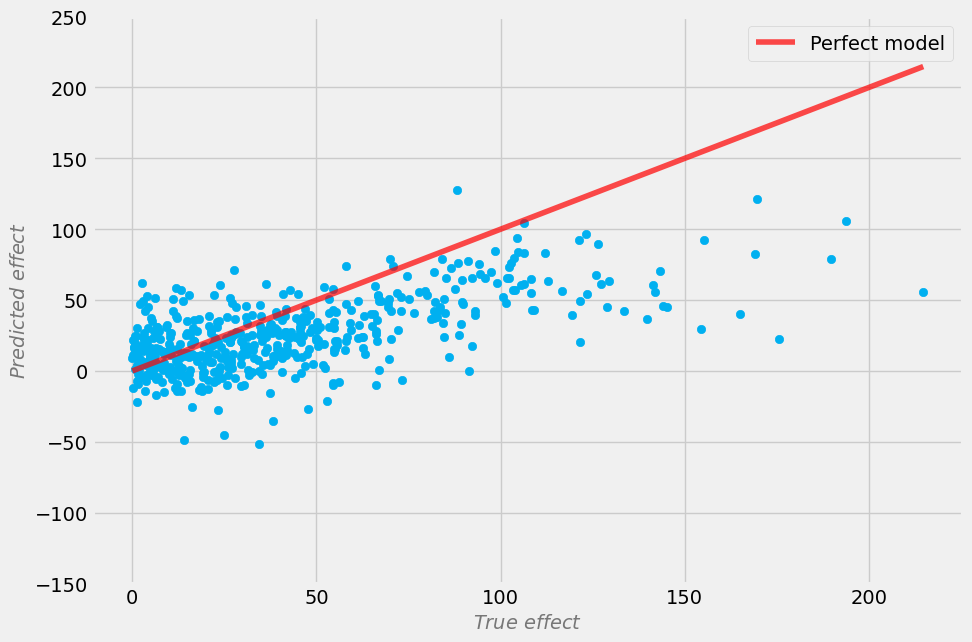

In [28]:
for model_name in benchmark_results.keys():
    effect_pred = benchmark_results[model_name]
    print(f'{model_name} MAPE = {mean_absolute_percentage_error(effect_true, effect_pred)}')
    
    plot_effect(
        effect_true=effect_true,
        effect_pred=effect_pred,
        ylim=(-150, 250)
    )

### TARNet

In [15]:
tarnet = TARNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

tarnet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);


In [16]:
# Get predictions
effect_pred_tarnet = tarnet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [17]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_tarnet)

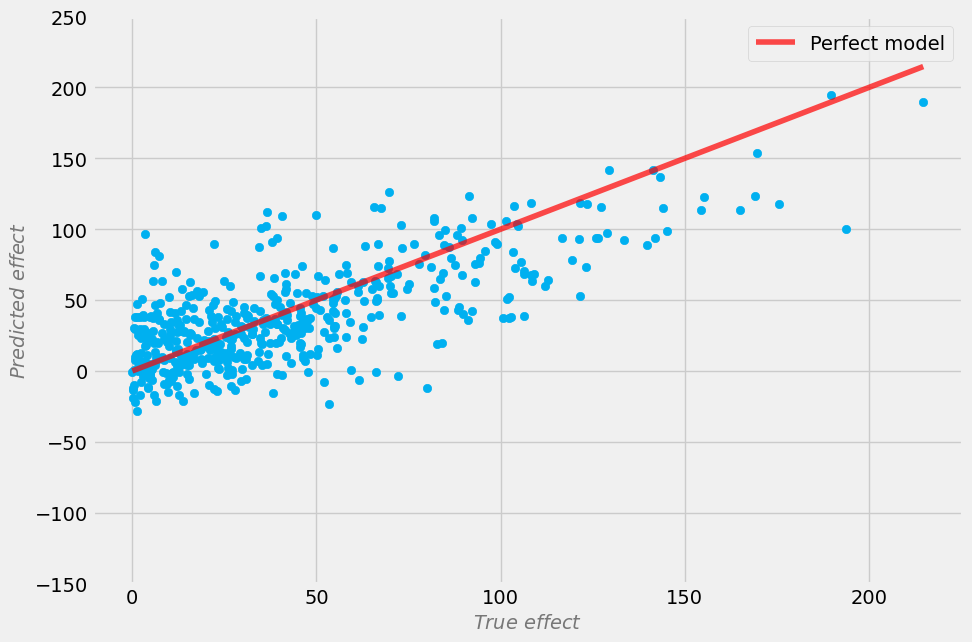

In [19]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred_tarnet,
    ylim=(-150, 250)
)

### SNet

In [20]:
snet = SNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

snet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);

In [21]:
effect_pred_snet = snet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [22]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_snet)

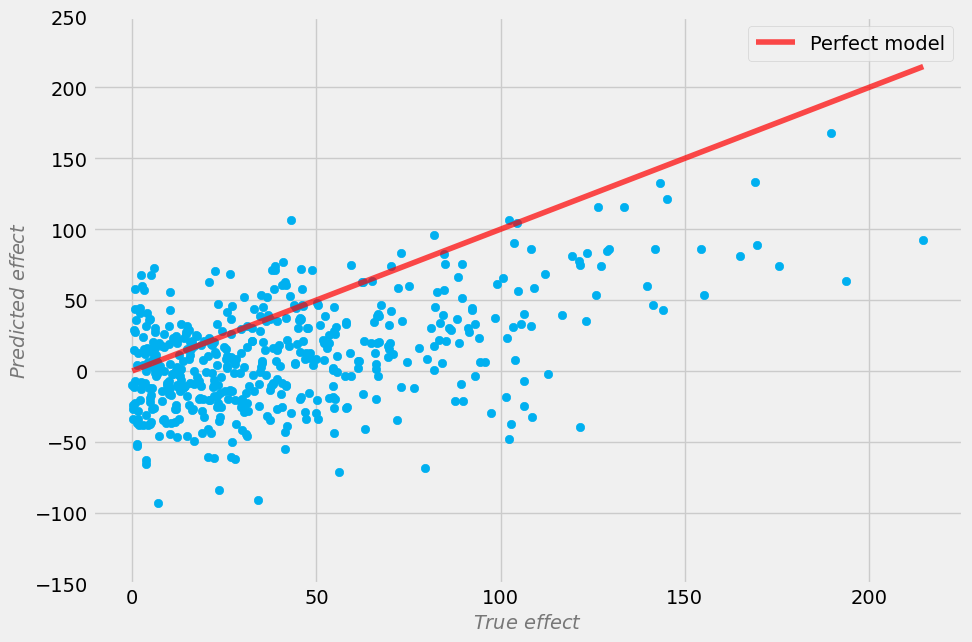

In [24]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred_snet,
    ylim=(-150, 250)
)

## Transformers and Causal Inference

### Data

In [29]:
# Read-in
df = pd.read_csv('data/manga_processed.csv')          

In [30]:
# Shuffle observations
df = df.sample(frac=1)

In [31]:
df.head()

,text,subreddit,female_avatar,has_photo,upvote
192,I'm in love with 'My Hero Academia' and its th...,manga,0,1,1
119,'Vinland Saga' is a captivating and emotional ...,manga,0,1,1
129,'Jojo's Bizarre Adventure' is a wild and creat...,manga,0,1,1
113,I'm blown away by 'Bleach' and its epic and my...,manga,0,0,1
96,Looking for manga that address the themes of s...,manga,1,1,0


In [32]:
df.shape

### Modeling

In [33]:
# # Re-running the model training? Un-comment the lines below and collect garbarge to free the GPU memory
# import gc
# del causal_bert
# gc.collect()
# torch.cuda.empty_cache()

torch.cuda.is_available()

NameError: name 'causal_bert' is not defined

In [34]:
# Instantiate the model
causal_bert = CausalBertWrapper(
    batch_size=8,                      
    g_weight=0.05, 
    Q_weight=1., 
    mlm_weight=0.05
)

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jakep\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
Some weights of CausalBert were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.1.0.bias', 'Q_cls.1.2.weight', 'Q_cls.0.2.bias', 'Q_cls.1.2.bias', 'g_cls.weight', 'Q_cls.0.0.weight', 'g_cls.bias', 'Q_cls.0.0.bias

In [35]:
# Train
causal_bert.train(
    texts=df['text'], 
    confounds=df['has_photo'], 
    treatments=df['female_avatar'], 
    outcomes=df['upvote'], 
    epochs=6
);

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
100%|██████████| 28/28 [00:04<00:00,  6.55it/s]


In [36]:
# Predict
preds = causal_bert.inference(
    texts=df['text'],
    confounds=df['has_photo'], 
)[0]

100%|██████████| 28/28 [00:00<00:00, 30.45it/s]


In [37]:
# Compute ATE
np.mean(preds[:, 1] - preds[:, 0])